In [27]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import neighbors
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import re
from pylab import plot, show
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

/kaggle/input/goodreadsbooks/books.csv


In [28]:
df = pd.read_csv('/kaggle/input/goodreadsbooks/books.csv', error_bad_lines = False)
dataset_for_recommendation = df.copy()
df[:50]

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 3350: expected 12 fields, saw 13\nSkipping line 4704: expected 12 fields, saw 13\nSkipping line 5879: expected 12 fields, saw 13\nSkipping line 8981: expected 12 fields, saw 13\n'


,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic
5,9,"Unauthorized Harry Potter Book Seven News: ""Ha...",W. Frederick Zimmerman,3.74,0976540606,9780976540601,en-US,152,19,1,4/26/2005,Nimble Books
6,10,Harry Potter Collection (Harry Potter #1-6),J.K. Rowling,4.73,0439827604,9780439827607,eng,3342,28242,808,9/12/2005,Scholastic
7,12,The Ultimate Hitchhiker's Guide: Five Complete...,Douglas Adams,4.38,0517226952,9780517226957,eng,815,3628,254,11/1/2005,Gramercy Books
8,13,The Ultimate Hitchhiker's Guide to the Galaxy ...,Douglas Adams,4.38,0345453743,9780345453747,eng,815,249558,4080,4/30/2002,Del Rey Books
9,14,The Hitchhiker's Guide to the Galaxy (Hitchhik...,Douglas Adams,4.22,1400052920,9781400052929,eng,215,4930,460,8/3/2004,Crown


In [29]:
df.index = df['bookID']

In [30]:
df.shape

(11123, 12)

In [31]:
df.replace(to_replace='J.K. Rowling-Mary GrandPré', value = 'J.K. Rowling', inplace=True)

In [32]:
df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
bookID,,,,,,,,,,,,
1,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
2,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
4,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
5,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
8,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


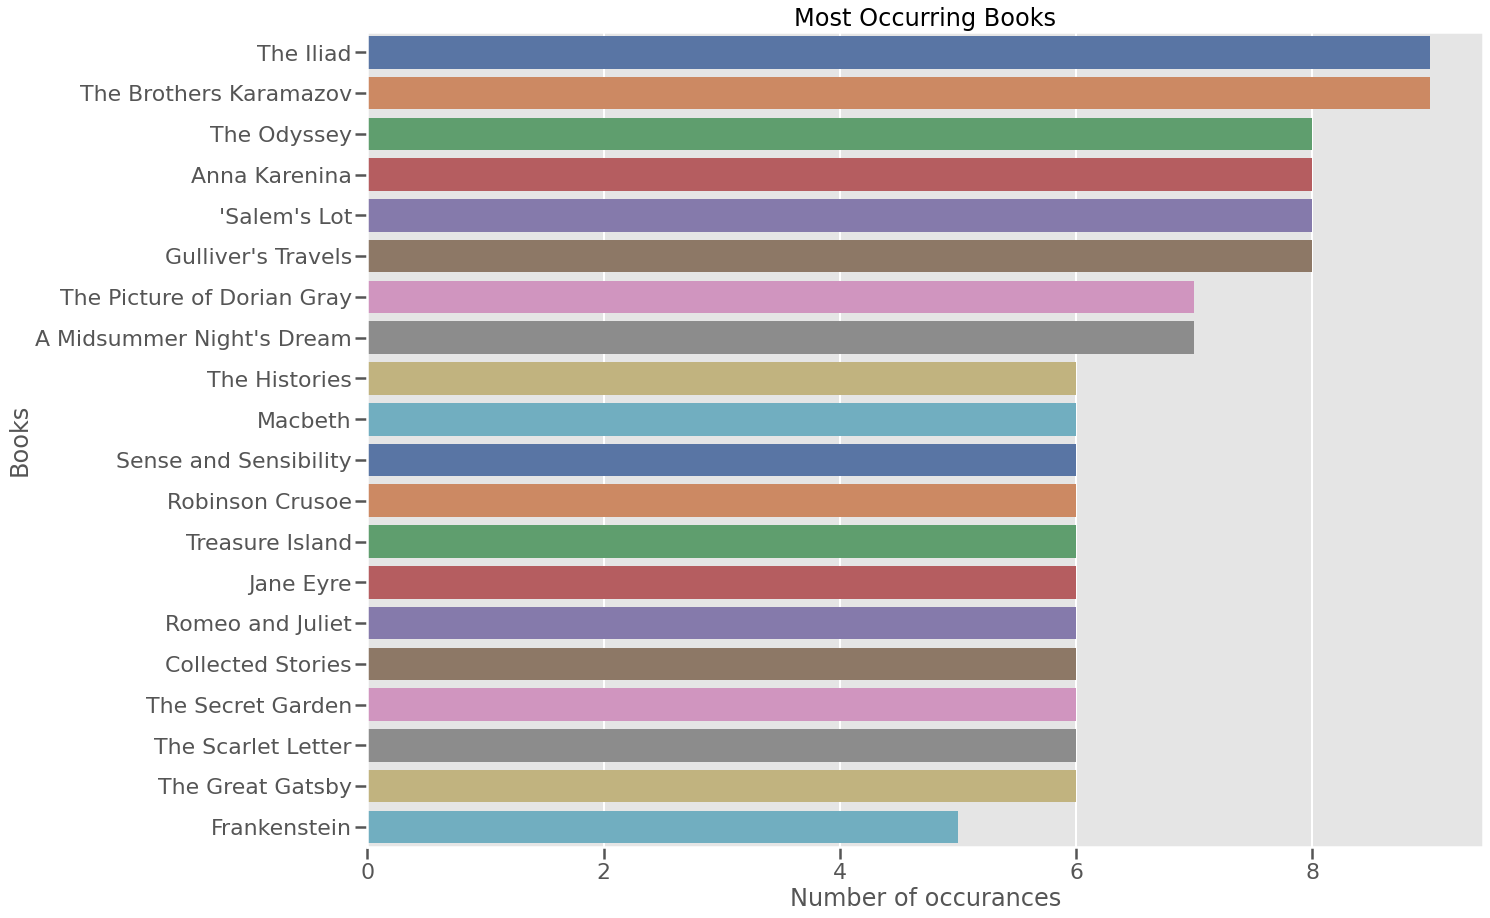

In [33]:
sns.set_context('poster')
plt.figure(figsize=(20,15))
books = df['title'].value_counts()[:20]
rating = df.average_rating[:20]
sns.barplot(x = books, y = books.index, palette='deep')
plt.title("Most Occurring Books")
plt.xlabel("Number of occurances")
plt.ylabel("Books")
plt.show()

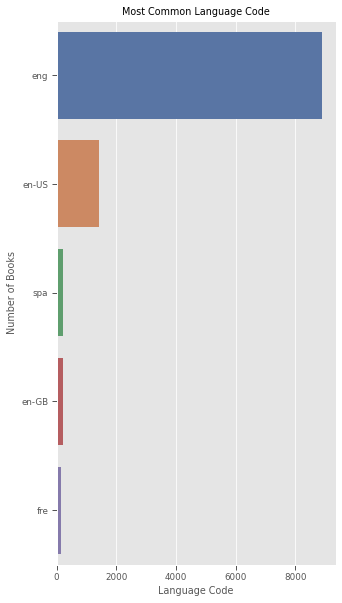

In [34]:
sns.set_context('paper')
plt.figure(figsize=(5, 10))
books = df['language_code'].value_counts()[:5]
sns.barplot(x=books, y=books.index, palette='deep')
plt.title("Most Common Language Code")
plt.xlabel("Language Code")
plt.ylabel("Number of Books")
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='ratings_count', ylabel='title'>

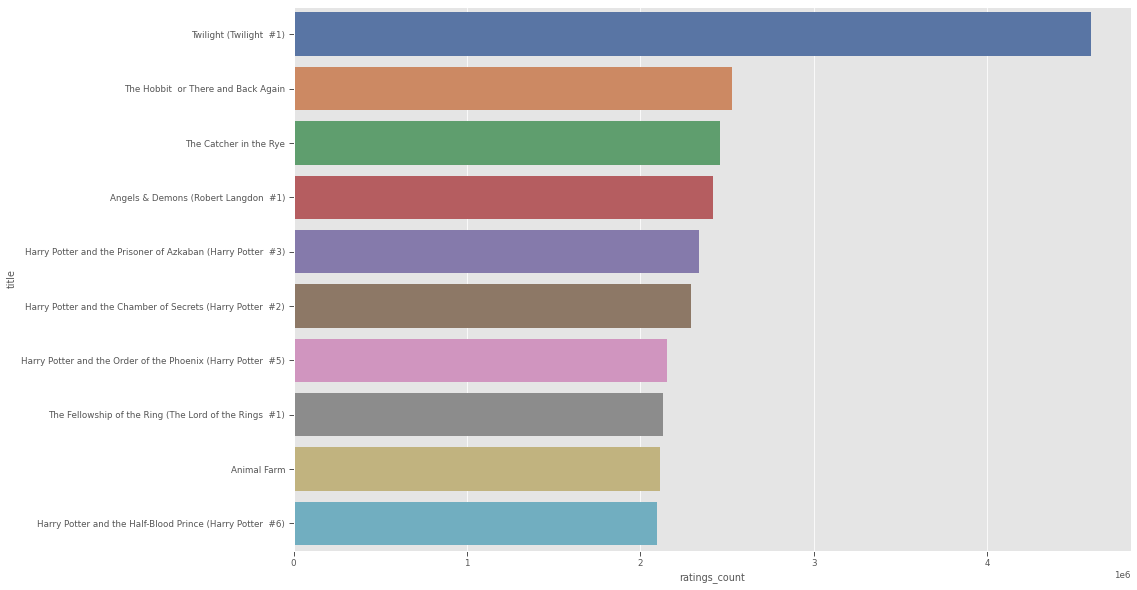

In [35]:
most_rated = df.sort_values('ratings_count', ascending = False).head(10).set_index('title')
plt.figure(figsize=(15,10))
sns.barplot(most_rated['ratings_count'], most_rated.index, palette='deep')

Creating a copy of the original dataset. Then, creating a new column called 'rating_range' to map the range of average ratings. For example if the average rating is 3.6, the value of that row would be '3 and 4'

<AxesSubplot:ylabel='publisher'>

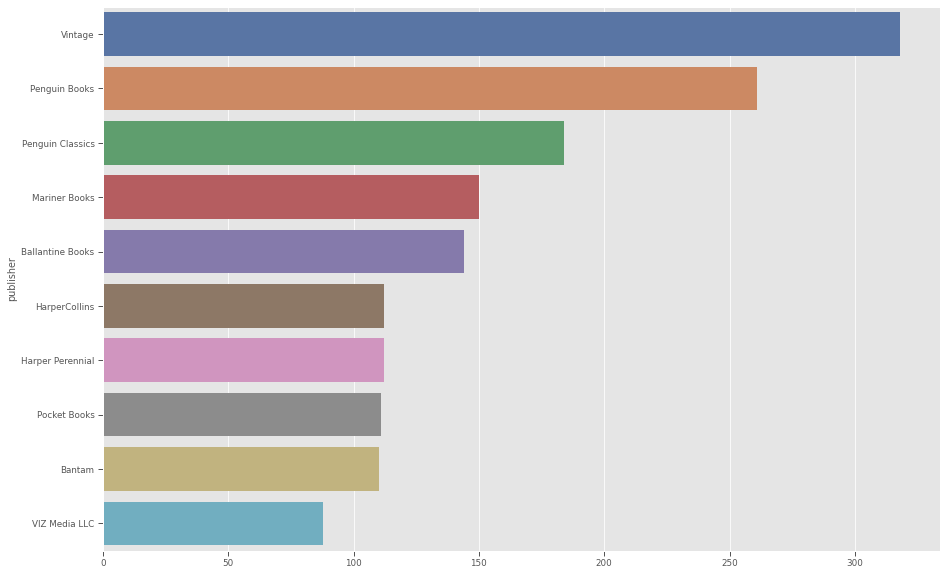

In [36]:
publisher = df.value_counts('publisher').head(10)
plt.figure(figsize=(15,10))
sns.barplot(y=publisher.index,x = publisher, palette='deep')

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of Number of Pages in a book')

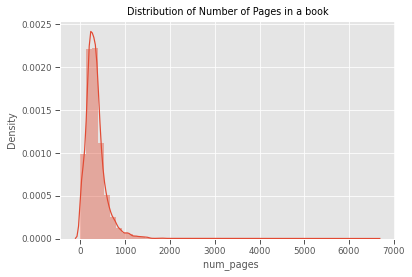

In [37]:
sns.distplot(df['  num_pages'])
plt.title('Distribution of Number of Pages in a book')

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


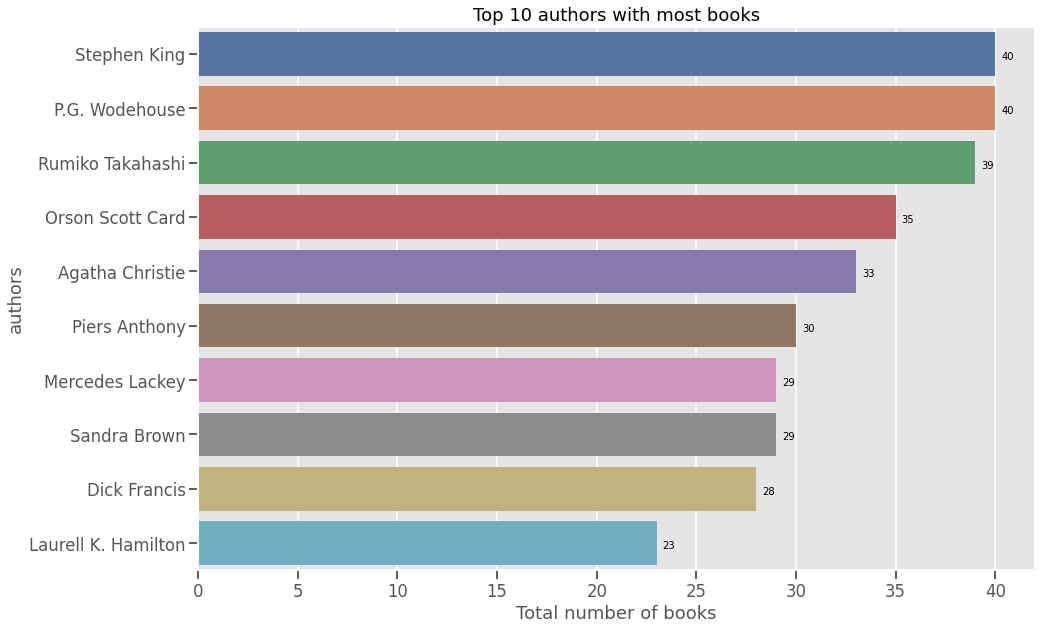

In [38]:
sns.set_context('talk')
most_books = df.groupby('authors')['title'].count().reset_index().sort_values('title', ascending=False).head(10).set_index('authors')
plt.figure(figsize=(15,10))
ax = sns.barplot(most_books['title'], most_books.index, palette='deep')
ax.set_title("Top 10 authors with most books")
ax.set_xlabel("Total number of books")
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+0.5, str(round(i.get_width())), fontsize = 10, color = 'k')

In [39]:
dataset_for_recommendation.loc[(dataset_for_recommendation["average_rating"] >= 0) & (dataset_for_recommendation['average_rating'] < 1), 'rating_range'] = "0-1" 
dataset_for_recommendation.loc[(dataset_for_recommendation["average_rating"] >= 1) & (dataset_for_recommendation['average_rating'] < 2), 'rating_range'] = "1-2"
dataset_for_recommendation.loc[(dataset_for_recommendation["average_rating"] >= 2) & (dataset_for_recommendation['average_rating'] < 3), 'rating_range'] = "2-3"
dataset_for_recommendation.loc[(dataset_for_recommendation["average_rating"] >= 3) & (dataset_for_recommendation['average_rating'] < 4), 'rating_range'] = "3-4"
dataset_for_recommendation.loc[(dataset_for_recommendation["average_rating"] >= 4) & (dataset_for_recommendation['average_rating'] <= 5), 'rating_range'] = "4-5"

Encode the rating_range column and the language_code column since both are categorical variables now

In [40]:
label_encoder = LabelEncoder()
encoded_rating = label_encoder.fit_transform(dataset_for_recommendation['rating_range'])
encoded_language = label_encoder.fit_transform(dataset_for_recommendation['language_code'])

Concatenating these two columns into the main dataset and performing MinMaxScaler so that the entire dataset is normalized between 0 to 1 for nearest neighbors

In [41]:
concatenated_dataset = pd.concat([pd.Series(encoded_rating), pd.Series(encoded_language), dataset_for_recommendation['average_rating'], dataset_for_recommendation['ratings_count']], axis = 1)
min_max_scaler = MinMaxScaler()
features = min_max_scaler.fit_transform(concatenated_dataset)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Getting 10 nearest neighbors(in this case, 10 most similar books) by using kd_tree as the algorithm for Nearest Neighbors. Then, getting the distance matrix and the indices with the kneighbors function. Since it is a recommendation engine, it is unsupervised learning

In [42]:
nn_model = neighbors.NearestNeighbors(n_neighbors=11, algorithm = 'kd_tree')
nn_model.fit(features)
distance_matrix, ids_to_list_matrix = nn_model.kneighbors(features)

Creating two functions to get book recommendations by name and by rating. We search for the exact book title and from the trained model, we fetch books with similar features. In case of ratings, we filter out books greater than or equal to the given rating

In [43]:
def book_recommendation_by_name(name):
    books = []
    idx = dataset_for_recommendation[dataset_for_recommendation['title'] == name].index
    idx = idx[0]
    for num in ids_to_list_matrix[idx]:
        books.append(dataset_for_recommendation.loc[num].title)
    return books

def book_recommendation_by_author(author):
    books = []
    idx = dataset_for_recommendation[dataset_for_recommendation['authors'] == author].index
    idx = idx[0]
    for num in ids_to_list_matrix[idx]:
        books.append(dataset_for_recommendation.loc[num].title)
    return books

[1:] to ignore the input in the output list

In [44]:
book_recommendation_by_name("Harry Potter and the Order of the Phoenix (Harry Potter  #5)")[1:]

['Harry Potter and the Half-Blood Prince (Harry Potter  #6)',
 'The Fellowship of the Ring (The Lord of the Rings  #1)',
 'Harry Potter and the Chamber of Secrets (Harry Potter  #2)',
 'Harry Potter and the Prisoner of Azkaban (Harry Potter  #3)',
 'The Hobbit  or There and Back Again',
 'The Lightning Thief (Percy Jackson and the Olympians  #1)',
 'The Book Thief',
 'The Giver (The Giver  #1)',
 'Little Women',
 'Jane Eyre']

In [45]:
book_recommendation_by_name("The Control of Nature")[1:]

['The Invisibles  Vol. 6: Kissing Mister Quimper',
 'The Bitten (Vampire Huntress  #4)',
 'Flap Your Wings',
 'White Fang',
 'The Only Dance There Is',
 'What Christians Believe',
 'Sensual Phrase  Vol. 17',
 'The Bradbury Chronicles: The Life of Ray Bradbury',
 'This Is Berlin: Reporting from Nazi Germany 1938-40',
 'Beyond the Post-Modern Mind: The Place of Meaning in a Global Civilization']

In [46]:
book_recommendation_by_author('J.R.R. Tolkien')

['J.R.R. Tolkien 4-Book Boxed Set: The Hobbit and The Lord of the Rings',
 'The Complete Maus',
 'The Calvin and Hobbes Tenth Anniversary Book',
 'Season of Mists (The Sandman  #4)',
 'The Lord of the Rings: The Art of the Fellowship of the Ring',
 'Collected Fictions',
 'Fullmetal Alchemist  Vol. 1 (Fullmetal Alchemist  #1)',
 'Harry Potter and the Goblet of Fire (Harry Potter  #4)',
 'The Complete Novels',
 'Fullmetal Alchemist  Vol. 3 (Fullmetal Alchemist  #3)',
 'The Wake (The Sandman  #10)']

## Cosine Similarity

In [47]:
def book_recommendation_by_name_cosine(title):
    book_id = 0
    index = dataset_for_recommendation.index[dataset_for_recommendation['title'] == title].to_list()
    if index:
        book_id = index[0]
    if book_id is None:
        print("No such book")
        return None
    else:
        data = list(enumerate(cosine_sim[book_id]))
        data = sorted(data, key=lambda x: x[1], reverse=True)
        #get top 10
        books = data[1:11]
        indices = [x[0] for x in books]
        result = dataset_for_recommendation['title'].iloc[indices]
    return result

In [48]:
tfidf = TfidfVectorizer(stop_words='english').fit_transform(dataset_for_recommendation['title'])
cosine_sim = cosine_similarity(tfidf, tfidf)

In [49]:
book_recommendation_by_name_cosine('Harry Potter and the Order of the Phoenix (Harry Potter  #5)')

6             Harry Potter Collection (Harry Potter  #1-6)
10675    Harry Potter and the Goblet of Fire (Harry Pot...
2        Harry Potter and the Chamber of Secrets (Harry...
4415     Harry Potter and the Chamber of Secrets (Harry...
10674    Harry Potter and the Philosopher's Stone (Harr...
8873     Harry Potter and the Sorcerer's Stone (Harry P...
0        Harry Potter and the Half-Blood Prince (Harry ...
615      Harry Potter and the Half-Blood Prince (Harry ...
3        Harry Potter and the Prisoner of Azkaban (Harr...
1233     Harry Potter and the Prisoner of Azkaban (Harr...
Name: title, dtype: object

In [50]:
book_recommendation_by_name_cosine('The Control of Nature')

4234                                         Total Control
3599                                           Nature Girl
5525                               The Nature of the Child
9698                             Super Fast Out of Control
8303                   Philosophy and the Mirror of Nature
652                           The Nature of Space and Time
7131                   Under the Sea Wind (Nature Classic)
5349                      Beatrix Potter: A Life in Nature
5628          Line of Control (Tom Clancy's Op-Center  #8)
10210    As Nature Made Him: The Boy Who Was Raised as ...
Name: title, dtype: object